# Model Predictive Control 

In [179]:
# %matplotlib widget
import importlib.util
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import ode
from scipy.interpolate import interp1d
# Define the file path
file_path = '/home/austin/Drone_AFRL/MPC_DRONE.py'

# Define the module name
module_name = 'MPC_DRONE'

# Load the module
spec = importlib.util.spec_from_file_location(module_name, file_path)
MPCD = importlib.util.module_from_spec(spec)
sys.modules[module_name] = MPCD
spec.loader.exec_module(MPCD)

Hello from MPC_DRONE.py


In [231]:
TIME=1
dt=.1
T_length=int(TIME/dt)
# make vx sin wave
t = np.linspace(0,T_length*dt,T_length)
# set vz to t^2 for half the time then t for the other half startign from when t^2 ends
x=np.array([0.0])
y=np.array([0.0])
z=np.array([0.0])
vx = np.full (T_length,1)
vy = np.full (T_length,1)
# vy = 5*np.cos(t/2)
vz = np.full (T_length,0)
phi=np.array([0.0])
theta=np.array([0.0])
psi=np.arctan2(vx,vy)
phidot=np.array([0.0])
thetadot=np.array([0.0])
psidot=np.array([0.0])
# creat a dictionary of the states
states={'x':x,'vx':vx,'y':y,'vy':vy,'z':z,'vz':vz,'phi':phi,'phidot':phidot,'theta':theta,'thetadot':thetadot,'psi':psi,'psidot':psidot}
# psi= np.full (T_length,0)
# params
m = 5.5 #kg mass
l = 0.4 #m length
Ix = 1.0 #kg*m^2 moment of inertia
Iy = 1.0 #kg*m^2 moment of inertia
Iz = 1.0 #kg*m^2 moment of inertia
Jr = 1.0 #kg*m^2 polar moment of inertia
b = 1.0 # thrust coefficient
d = 1.0 # drag coefficient
Dl = 2.0 # drag coefficient from ground speed
Dr = 2.0 # drag coefficient from rotation speed
g=9.81 #m/s^2 gravity
params=[m,l,Ix,Iy,Iz,Jr,b,d,Dl,Dr]
X_start=[x[0],vx[0],y[0],vy[0],z[0],vz[0],phi[0],phidot[0],theta[0],thetadot[0],psi[0],psidot[0]]
U_start=[0,0,0,0]

In [232]:



mpc=MPCD.MpcDrone(x=x,vx=vx,y=y,vy=vy,z=z,vz=vz,phi=phi,phidot=phidot,theta=theta,thetadot=thetadot,psi=psi,psidot=psidot,params=params,U_start=U_start,X_start=X_start,dt=dt, n_horizon=10, r_weight=0.0)

In [233]:
# make function that runs the mpc and returns the new state and control for a given duration then only takes the first control input and runs the mpc again for a longer duration
def mpc_run(X_start, U_start,states,dt,t,T):
    X_new=[]
    U_new=[]

    tl=int(t/dt)
    X_new.append(X_start)
    U_new.append(U_start)
    # for i = 0
    mpc=MPCD.MpcDrone(x=states['x'][0:tl],
                      vx=states['vx'][0:tl],
                      y=states['y'][0:tl],
                      vy=states['vy'][0:tl],
                      z=states['z'][0:tl],
                      vz=states['vz'][0:tl],
                      phi=states['phi'][0:tl],
                      phidot=states['phidot'][0:tl],
                      theta=states['theta'][0:tl],
                      thetadot=states['thetadot'][0:tl],
                      psi=states['psi'][0:tl],
                      psidot=states['psidot'][0:tl],
                      params=params,
                      U_start=U_new,
                      X_start=X_new,
                      dt=dt,
                      n_horizon=10,
                      r_weight=1)
    x,u=mpc.get_X_and_U()
    U_new.append(u[1])
    X_new.append(x[1])
    for i in range(2,T):
        if i+tl > T:
            break
        else:
            mpc=MPCD.MpcDrone(x=np.array(states['x'][0:i+tl]),
                              vx=states['vx'][i:i+tl],
                              y=states['y'][0:i+tl],
                              vy=states['vy'][i:i+tl],
                              z=states['z'][0:i+tl],
                              vz=states['vz'][i:i+tl],
                              phi=states['phi'][0:i+tl],
                              phidot=states['phidot'][0:i+tl],
                              theta=states['theta'][0:i+tl],
                              thetadot=states['thetadot'][0:i+tl],
                              psi=states['psi'][i:i+tl],
                              psidot=states['psidot'][0:i+tl],
                              params=params,
                              U_start=U_new[i-1],
                              X_start=X_new[i-1],
                              dt=dt,
                              n_horizon=10,
                              r_weight=1)
            x,u=mpc.get_X_and_U()
            U_new.append(u[1])
            X_new.append(x[1])
    return np.array(X_new),np.array(U_new)

In [234]:
tl=.4

X_new,U_new=mpc_run(X_start,U_start,states,dt,tl,T_length)

In [247]:
X_new.T[1]

array([1.        , 0.97062665, 0.96932124, 0.97598796, 0.90223739,
       0.6139143 , 0.01522618])

In [236]:
# X,U=mpc.get_X_and_U()

# mpc.plot_states_targets_inputs()

In [130]:
print(U[-10:-1,0])
print(U[-10:-1,1])
print(U[-10:-1,2])
print(U[-10:-1,3])

[3.67420872 3.67435912 3.67439202 3.67433155 3.67421415 3.67407799
 3.67395492 3.67386581 3.67381932]
[3.67250174 3.67336789 3.67412562 3.67465657 3.67491674 3.67492585
 3.67474708 3.67446361 3.67415732]
[3.67376727 3.67364531 3.67361546 3.67365919 3.67374907 3.67385611
 3.67395561 3.67403067 3.67407341]
[3.67538036 3.67448581 3.67372538 3.67321136 3.67297863 3.67299842
 3.67320057 3.67349801 3.67380807]


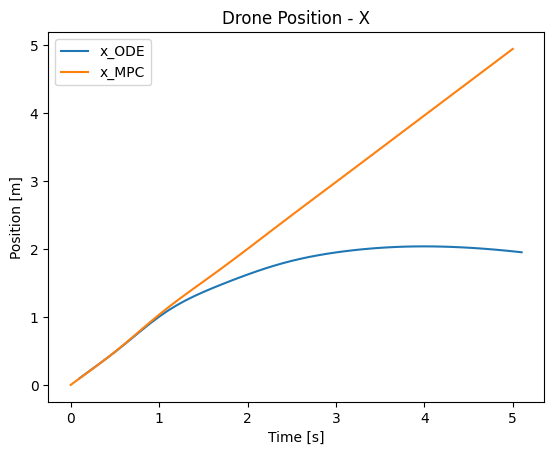

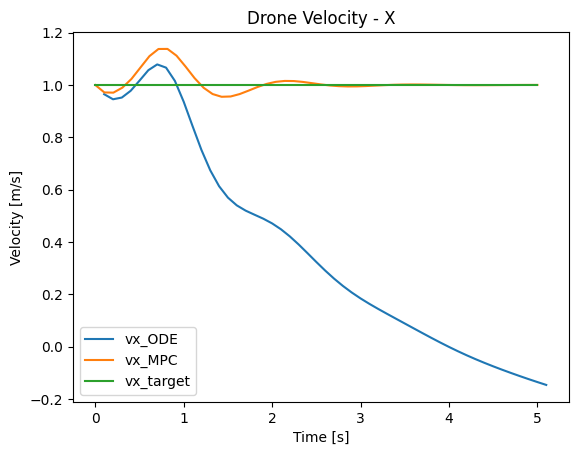

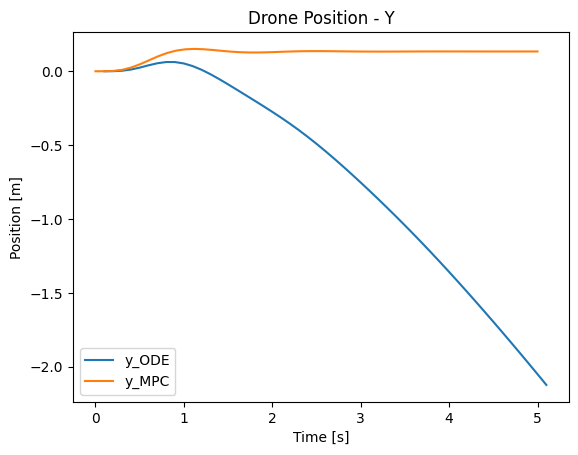

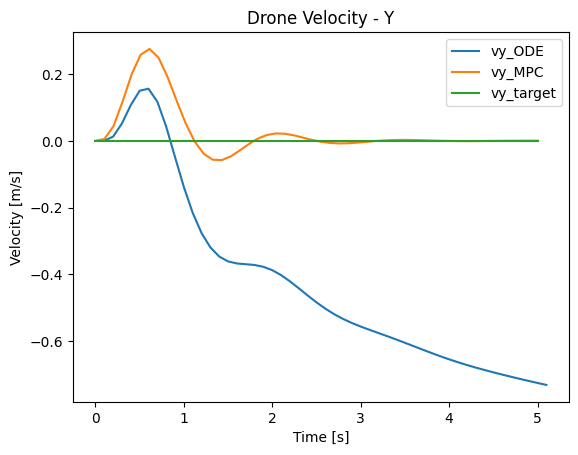

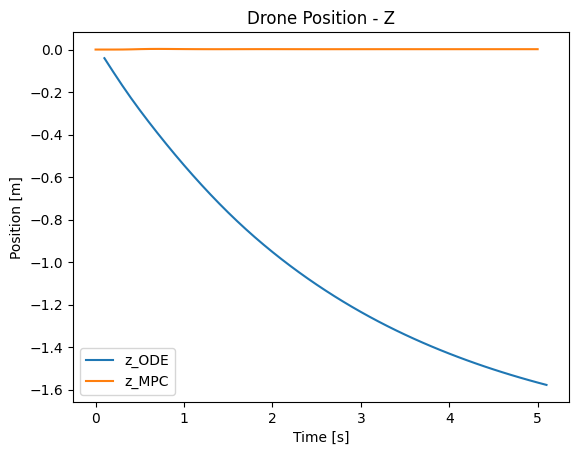

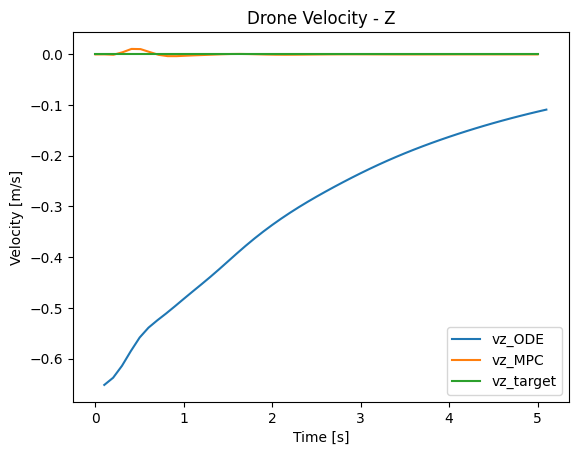

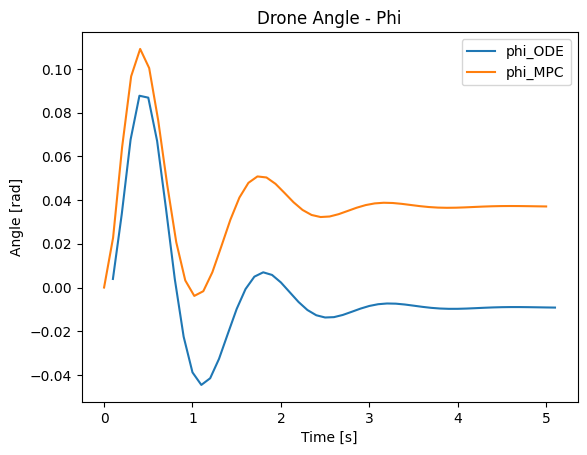

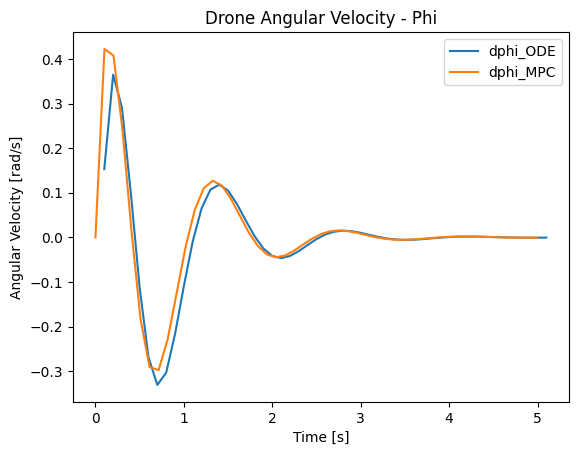

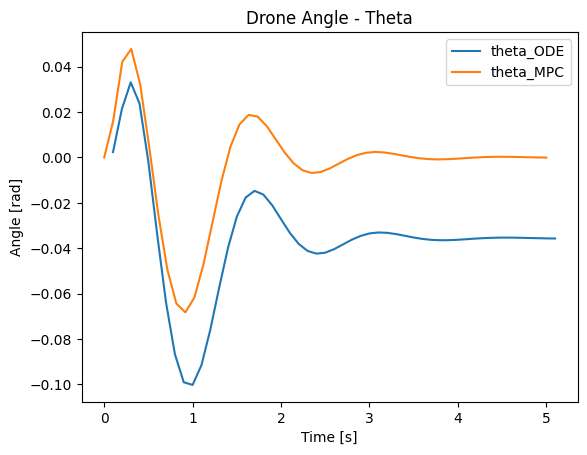

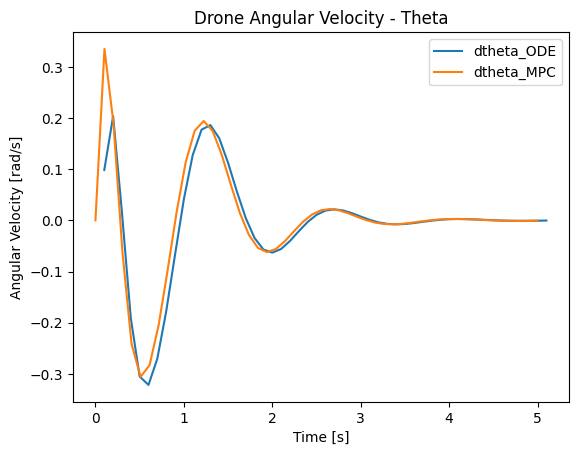

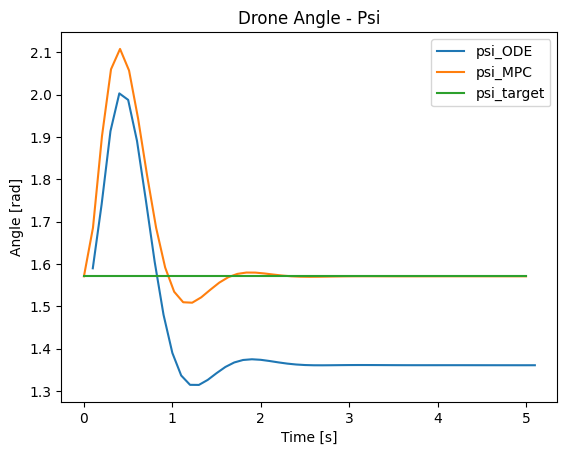

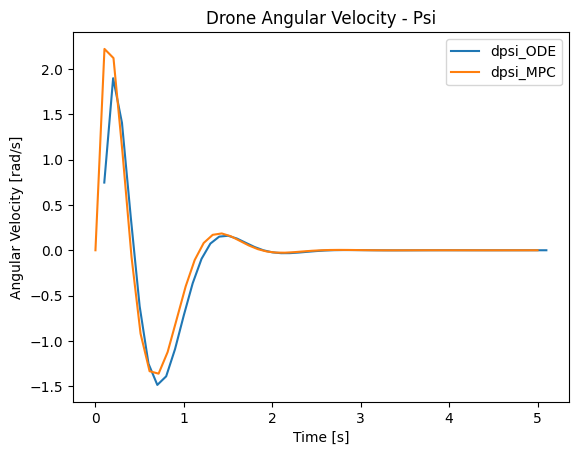

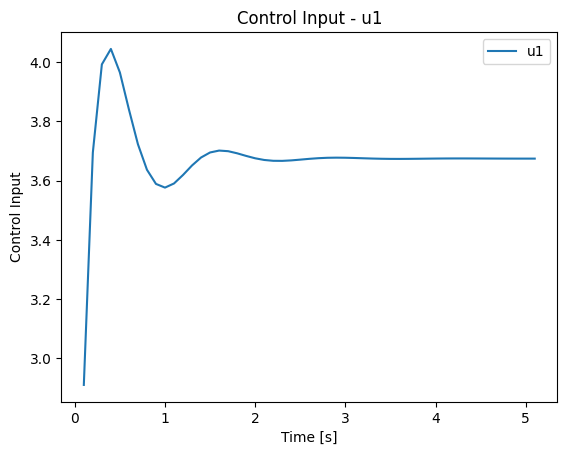

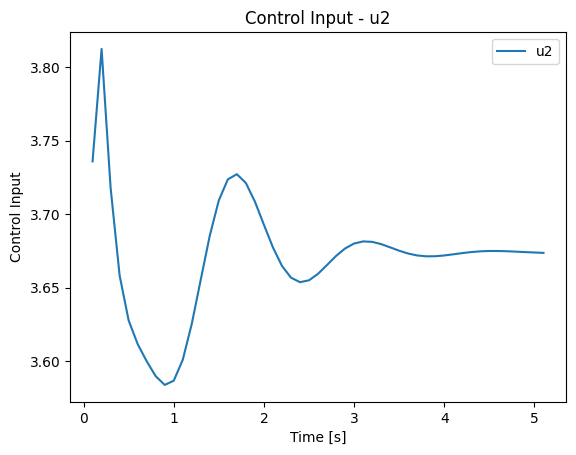

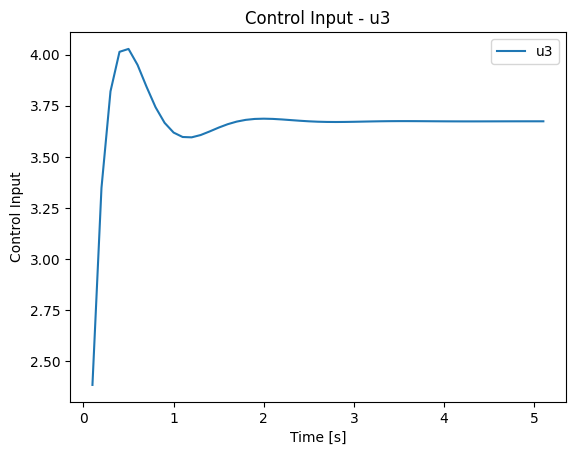

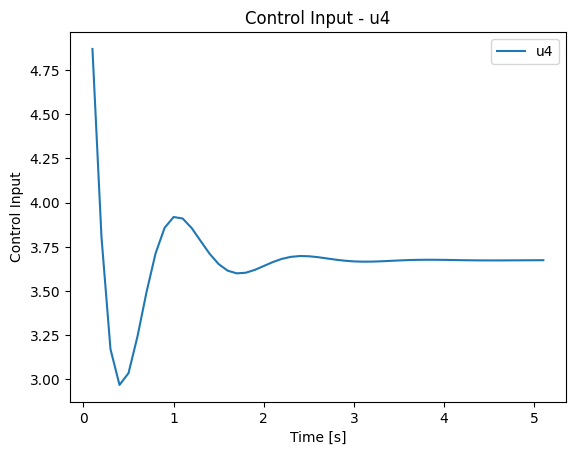

In [131]:


# Define the time-dependent inputs for each rotor
time_steps = np.linspace(0, TIME, T_length)
u1_input = U[:,0]
u2_input = U[:,1]
u3_input = U[:,2]
u4_input = U[:,3]

# Interpolate the control inputs
u1_interp = interp1d(time_steps, u1_input, fill_value="extrapolate")
u2_interp = interp1d(time_steps, u2_input, fill_value="extrapolate")
u3_interp = interp1d(time_steps, u3_input, fill_value="extrapolate")
u4_interp = interp1d(time_steps, u4_input, fill_value="extrapolate")

def drone_dynamics(t, state):
    # Extract state variables
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi = state

    # Get control inputs at current time step
    u1 = u1_interp(t)
    u2 = u2_interp(t)
    u3 = u3_interp(t)
    u4 = u4_interp(t)

    # Compute intermediate variables
    U1 = b * (u1**2 + u2**2 + u3**2 + u4**2)
    U2 = b * (u4**2 + u1**2 - u2**2 - u3**2)
    U3 = b * (u3**2 + u4**2 - u1**2 - u2**2)
    U4 = d * (-u1**2 + u2**2 - u3**2 + u4**2)
    Omega = u2 + u4 - u1 - u3
    
    dx = vx
    dvx = (1/m) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Dl * vx / m)
    dy = vy
    dvy = (1/m) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Dl * vy / m)
    dz = vz
    dvz = (1/m) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Dl * vz / m)
    dphi = dphi
    ddphi = dtheta * dpsi * (Iy - Iz) / Ix - (Jr * dtheta * Omega / Ix) + (U2 * l / Ix) - (Dr * dphi / Ix)
    dtheta = dtheta
    ddtheta = dphi * dpsi * (Iz - Ix) / Iy + (Jr * dphi * Omega / Iy) + (U3 * l / Iy) - (Dr * dtheta / Iy)
    dpsi = dpsi
    ddpsi = dphi * dtheta * (Ix - Iy) / Iz + (U4 / Iz) - (Dr * dpsi / Iz)
    
    return [dx, dvx, dy, dvy, dz, dvz, dphi, ddphi, dtheta, ddtheta, dpsi, ddpsi]

# Initial conditions
initial_state = X_start

# # Time span
# t_span = (0, TIME)  # simulate for 5 seconds
# t_eval = np.linspace(0, TIME, T_length)  # time points where the solution is evaluated

# # Solve the ODE
# solution = solve_ivp(drone_dynamics, t_span, initial_state, t_eval=t_eval, method='RK45')

# # Extract the solution
# time = solution.t
# new_x, new_vx, new_y, new_vy, new_z, new_vz, new_phi, new_dphi, new_theta, new_dtheta, new_psi, new_dpsi = solution.y

# Time span
t_span = (0, TIME)  # simulate for 5 seconds

# Create an instance of the ODE solver
solver = ode(drone_dynamics).set_integrator('dopri5')  # You can also try 'dop853' or 'vode'
solver.set_initial_value(initial_state, t_span[0])

# Time evaluation points
t_eval = np.linspace(0, TIME, T_length)

# Arrays to store the results
states = []
times = []

# Perform the integration
while solver.successful() and solver.t < t_span[1]:
    solver.integrate(solver.t + dt)
    times.append(solver.t)
    states.append(solver.y)

# Convert the results to numpy arrays
states = np.array(states)
time = np.array(times)

# Extract the solution
new_x, new_vx, new_y, new_vy, new_z, new_vz, new_phi, new_dphi, new_theta, new_dtheta, new_psi, new_dpsi = states.T


# Plot the solution
plt.figure()
plt.plot(time, new_x, label='x_ODE')
plt.plot(t,X.T[0],label='x_MPC')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Drone Position - X')
plt.legend()

plt.figure()
plt.plot(time, new_vx, label='vx_ODE')
plt.plot(t,X.T[1],label='vx_MPC')
plt.plot(t,vx,label='vx_target')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Drone Velocity - X')
plt.legend()

plt.figure()
plt.plot(time, new_y, label='y_ODE')
plt.plot(t,X.T[2],label='y_MPC')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Drone Position - Y')
plt.legend()

plt.figure()
plt.plot(time, new_vy, label='vy_ODE')
plt.plot(t,X.T[3],label='vy_MPC')
plt.plot(t,vy,label='vy_target')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Drone Velocity - Y')
plt.legend()

plt.figure()
plt.plot(time, new_z, label='z_ODE')
plt.plot(t,X.T[4],label='z_MPC')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Drone Position - Z')
plt.legend()

plt.figure()
plt.plot(time, new_vz, label='vz_ODE')
plt.plot(t,X.T[5],label='vz_MPC')
plt.plot(t,vz,label='vz_target')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Drone Velocity - Z')
plt.legend()

plt.figure()
plt.plot(time, new_phi, label='phi_ODE')
plt.plot(t,X.T[6],label='phi_MPC')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Drone Angle - Phi')
plt.legend()

plt.figure()
plt.plot(time, new_dphi, label='dphi_ODE')
plt.plot(t,X.T[7],label='dphi_MPC')
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [rad/s]')
plt.title('Drone Angular Velocity - Phi')
plt.legend()

plt.figure()
plt.plot(time, new_theta, label='theta_ODE')
plt.plot(t,X.T[8],label='theta_MPC')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Drone Angle - Theta')
plt.legend()

plt.figure()
plt.plot(time, new_dtheta, label='dtheta_ODE')
plt.plot(t,X.T[9],label='dtheta_MPC')
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [rad/s]')
plt.title('Drone Angular Velocity - Theta')
plt.legend()

plt.figure()
plt.plot(time, new_psi, label='psi_ODE')
plt.plot(t,X.T[10],label='psi_MPC')
plt.plot(t,psi,label='psi_target')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Drone Angle - Psi')
plt.legend()

plt.figure()
plt.plot(time, new_dpsi, label='dpsi_ODE')
plt.plot(t,X.T[11],label='dpsi_MPC')
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [rad/s]')
plt.title('Drone Angular Velocity - Psi')
plt.legend()

plt.figure()
plt.plot(time, u1_interp(time), label='u1')
plt.xlabel('Time [s]')
plt.ylabel('Control Input')
plt.title('Control Input - u1')
plt.legend()

plt.figure()
plt.plot(time, u2_interp(time), label='u2')
plt.xlabel('Time [s]')
plt.ylabel('Control Input')
plt.title('Control Input - u2')
plt.legend()

plt.figure()
plt.plot(time, u3_interp(time), label='u3')
plt.xlabel('Time [s]')
plt.ylabel('Control Input')
plt.title('Control Input - u3')
plt.legend()

plt.figure()
plt.plot(time, u4_interp(time), label='u4')
plt.xlabel('Time [s]')
plt.ylabel('Control Input')
plt.title('Control Input - u4')
plt.legend()


plt.show()


In [132]:
print(u1_interp(time))

[2.91081683 3.69430421 3.99150913 4.04363038 3.96409458 3.83964314
 3.72228128 3.63623752 3.58850663 3.57606071 3.59000423 3.61870334
 3.6507769  3.67758241 3.69451834 3.70091011 3.69885863 3.69173319
 3.68289104 3.6748991  3.66925256 3.66644148 3.66619814 3.66780067
 3.67035883 3.67304241 3.67523229 3.67658858 3.67704356 3.67673994
 3.67594171 3.67494438 3.67400435 3.67329691 3.67290321 3.67281998
 3.67298329 3.67329747 3.67366232 3.67399372 3.67423579 3.67436439
 3.67438355 3.67431746 3.67420053 3.67406814 3.67394958 3.67386395
 3.6738192  3.67381344 3.67380767]
